In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time
from torch.utils.data import Dataset, DataLoader
from statistics import mode
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
import math
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

### **Model Construction**

In [ ]:
# Positional encoding

#Here we will preform positional encoding using Pytorch
class PositionalEncoding(nn.Module):
   # embedding_dim: dimensionality of the embeddings and max_seq_length: maximum sequence length ( in our case number of features)
   # dropout: for each training iteration, approximately 10% of the neurons in the dropout layer will be randomly set to zero.
   # register_buffer: used to register a tensor as a buffer in the model.

    def __init__(self, embedding_dim, max_seq_length=10):
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim
        self.max_seq_length = max_seq_length
        self.dropout = nn.Dropout(0.1)
        self.register_buffer('positional_encoding', self.calculate_positional_encoding())

    # This method computes the positional encoding matrix.

    def calculate_positional_encoding(self):

        # unsqueeze function is used to add a dimension with size 1.
        # position is a tensor representing the position of each element in the sequence.

        position = torch.arange(0, self.max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.embedding_dim, 2).float() * (-math.log(10000.0) / self.embedding_dim))
        positional_encoding = torch.zeros(self.max_seq_length, self.embedding_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding.unsqueeze(0)

    # This method adds the precomputed positional encoding to the input tensor, applies dropout to the modified tensor and returns the result.
    def forward(self, x):
        x = x + self.positional_encoding[:, :x.size(1)]
        return self.dropout(x)

# Define the encoder layer
class TransformerEncoderLayer(nn.Module):
    # num_heads: The number of heads in the multihead attention mechanism.
    # ff_dim: The dimensionality of the feedforward layer's intermediate representation.
    # dropout: The dropout rate, with a default value of 0.1.
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.multihead_attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout)
        self.feedforward = nn.Sequential(

            # The first linear transformation in the feedforward layer takes the input tensor with embedding_dim dimensions
            # and transforms it into an intermediate representation with ff_dim dimensions.
            nn.Linear(embedding_dim, ff_dim),
            # ReLU introduces non-linearity by replacing negative values with zero.
            nn.ReLU(),
            #The second linear transformation takes the representation with ff_dim dimensions
            # and transforms it back to the original embedding dimensionality.
            nn.Linear(ff_dim, embedding_dim)
        )
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # retrieve attention output from the multihead_attention
        # x, x, x represent : Q, K, V
        attn_output, _ = self.multihead_attention(x, x, x)
        x = x + self.dropout(attn_output)
        # Layer normalization is applied to the sum of the input tensor and the attention output.
        x = self.layer_norm1(x)
        ff_output = self.feedforward(x)
        x = x + self.dropout(ff_output)
        x = self.layer_norm2(x)
        return x

# Define the transformer encoder stack
class TransformerEncoder(nn.Module):

    # num_layers: The number of transformer encoder layers in the stack.
    # embedding_dim: The dimensionality of the input and output embeddings.
    # num_heads: The number of heads in the multihead attention mechanism.
    # ff_dim: The dimensionality of the feedforward layer's intermediate representation.
    # max_seq_length: The maximum sequence length (used for positional encoding).
    # dropout: The dropout rate, with a default value of 0.1.

    def __init__(self, num_layers, embedding_dim, num_heads, ff_dim, max_seq_length, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])
        self.positional_encoding = PositionalEncoding(embedding_dim, max_seq_length)

    def forward(self, x):
        x = self.positional_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x)
        return x

# Define the max-pooling layer
class MaxPoolingLayer(nn.Module):
    def forward(self, x):
        # Apply max-pooling along the sequence dimension (1D for sequential data)
        pooled_output, _ = x.max(dim=1)
        return pooled_output

# Define the Dense layer
class DenseLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DenseLayer, self).__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)

# Define the classifier layer
class ClassifierLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassifierLayer, self).__init__()
        self.classifier = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.classifier(x)

# Build the complete model
class CustomTransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, num_heads, ff_dim, max_seq_length, dropout=0.1):
        super(CustomTransformerModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.transformer_encoder = TransformerEncoder(num_layers, embedding_dim, num_heads, ff_dim, max_seq_length, dropout)
        self.max_pooling_layer = MaxPoolingLayer()
        self.dense_layer = DenseLayer(embedding_dim, 32)
        self.classifier_layer = ClassifierLayer(32, 1)

    def forward(self, x):
        # Embedding
        x = self.embedding_layer(x)

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Max-pooling
        x = self.max_pooling_layer(x)

        # Dense layer
        x = self.dense_layer(x)

        # Classifier layer
        x = self.classifier_layer(x)

        return x

# Create an instance of the model
vocab_size = 65535  # largest size of data (data is in Hexadecimal => largest possible value "FFFF" = 65535)
embedding_dim = 32  # embedding dimension
num_layers = 6  # Number of transformer layers
num_heads = 8  # Number of attention heads
ff_dim = 32  # Feedforward dimension
max_seq_length = 12  # number of features

model = CustomTransformerModel(vocab_size, embedding_dim, num_layers, num_heads, ff_dim, max_seq_length)


### **Data Preprocessing**



In [ ]:
def process_dataframe(df):
    # Identify and swap 'Flag' and 'DATA' values
    for index, row in df.iterrows():
        for col in ['DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']:
            value = row[col]
            if value == 'R' or value == 'T':
                df.at[index, 'Flag'] = value
                df.at[index, col] = np.nan

    # Check for duplicate rows
    #df = df.drop_duplicates()

    # Convert hexadecimal values to integers for the specified columns
    hex_columns = ['CAN ID', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']
    for col in hex_columns:
        df[col] = df[col].apply(lambda x: int(str(x), 16) if not pd.isna(x) and isinstance(x, str) else x)

    # Check for NaN values in data columns and replace with 256 if NaN exists
    data_columns = ['DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']
    df[data_columns] = df[data_columns].fillna(int(256))

    columns_to_convert = ['DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']
    for column in columns_to_convert:
        df[column] = df[column].astype('Int64')


    # Encode 'Flag' using LabelEncoder
    encoder = LabelEncoder()
    df['Flag'] = encoder.fit_transform(df['Flag'])
    df = df.drop(columns=['Timestamp'])
    #scaler = StandardScaler()
    #df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])
    return df

new_data = [[1478195721.903877, '0545', 8, 'd8', '00', '001', '8a', '002', '003', '004', '005', 'R']]
df1= pd.read_csv('Fuzzy_dataset.csv')
df1= pd.concat([pd.DataFrame(new_data, columns=df1.columns), df1], ignore_index=True)
df1.rename(columns={
    '1478195721.903877': 'Timestamp',
    '0545': 'CAN ID',
    '8': 'DLC',
    'd8': 'DATA0',
    '00': 'DATA1',
    '00.1': 'DATA2',
    '8a': 'DATA3',
    '00.2': 'DATA4',
    '00.3': 'DATA5',
    '00.4': 'DATA6',
    '00.5': 'DATA7',
    'R': 'Flag'
}, inplace=True)
 # Subset the DataFrame to keep the first 0.5% of rows
num_rows_to_keep = int(0.7 * len(df1))
df1 = df1.iloc[:num_rows_to_keep]
source = process_dataframe(df1)
source

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1349,8,216,0,1,138,2,3,4,5,0
1,688,5,255,127,0,5,73,256,256,256,0
2,2,8,0,0,0,0,0,1,7,21,0
3,339,8,0,33,16,255,0,255,0,0,0
4,304,8,25,128,0,255,254,127,7,96,0
...,...,...,...,...,...,...,...,...,...,...,...
199666,848,8,5,32,244,104,119,0,0,206,0
199667,1072,8,0,0,0,0,0,0,0,0,0
199668,1201,8,41,39,39,35,0,0,0,154,0
199669,497,8,8,0,0,0,0,0,0,0,0


In [ ]:
source['Flag'].value_counts()

0    170343
1     29328
Name: Flag, dtype: int64

### **Single Message Processing**

In [ ]:
X = source.iloc[:, :-1].values
y = source['Flag'].values

# Convert data to long type
X = X.astype(np.long)
y = y.astype(np.long)

train_features, test_features, train_target, test_target = train_test_split(X, y, test_size=0.30, random_state=42)

train_features_tensor = torch.tensor(train_features)
train_target_tensor = torch.tensor(train_target)
test_features_tensor = torch.tensor(test_features)
test_target_tensor = torch.tensor(test_target)

train_dataset = TensorDataset(train_features_tensor, train_target_tensor)
test_dataset = TensorDataset(test_features_tensor, test_target_tensor)

train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(train_features_tensor.size())
print(train_features_tensor[0])

torch.Size([139769, 10])
tensor([1764,    8,  188,  207,   98,   36,  146,  181,   86,  131])


<ipython-input-10-0dfcba027246>:6: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = X.astype(np.long)
<ipython-input-10-0dfcba027246>:7: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itsel

In [ ]:
# Define the loss function and optimizer
# Binary cross-entropy loss to measure the dissimilarity between predicted probabilities and true binary labels.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    total_loss = 0.0  # Initialize the total loss for the epoch

    for batch in train_data_loader:
        input_data, labels = batch

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(input_data)

        labels = labels.unsqueeze(1)

        # Calculate the loss
        loss = criterion(logits, labels.float())

        # Backward pass
        loss.backward()

        # Update the model's parameters
        optimizer.step()

        # Accumulate the loss for the epoch
        total_loss += loss.item()

    # Calculate and print the average loss for the epoch
    average_loss = total_loss / len(train_data_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")


Epoch 1/20, Loss: 0.0184
Epoch 2/20, Loss: 0.0026
Epoch 3/20, Loss: 0.0021
Epoch 4/20, Loss: 0.0009
Epoch 5/20, Loss: 0.0009
Epoch 6/20, Loss: 0.0012
Epoch 7/20, Loss: 0.0007
Epoch 8/20, Loss: 0.0009
Epoch 9/20, Loss: 0.0006
Epoch 10/20, Loss: 0.0009
Epoch 11/20, Loss: 0.0007
Epoch 12/20, Loss: 0.0007
Epoch 13/20, Loss: 0.0005
Epoch 14/20, Loss: 0.0008
Epoch 15/20, Loss: 0.0006
Epoch 16/20, Loss: 0.0006
Epoch 17/20, Loss: 0.0006
Epoch 18/20, Loss: 0.0007
Epoch 19/20, Loss: 0.0004
Epoch 20/20, Loss: 0.0002


In [ ]:
model.eval()  # Set the model to evaluation mode

CustomTransformerModel(
  (embedding_layer): Embedding(65535, 32)
  (transformer_encoder): TransformerEncoder(
    (encoder_layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (feedforward): Sequential(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
        (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (max_pooling_layer): MaxPoolingLayer()
  (dense_layer): DenseLayer(
    (dense): Linear(in_features=32, out_features=32, bias=True)
  

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50988
           1       1.00      1.00      1.00      8914

    accuracy                           1.00     59902
   macro avg       1.00      1.00      1.00     59902
weighted avg       1.00      1.00      1.00     59902



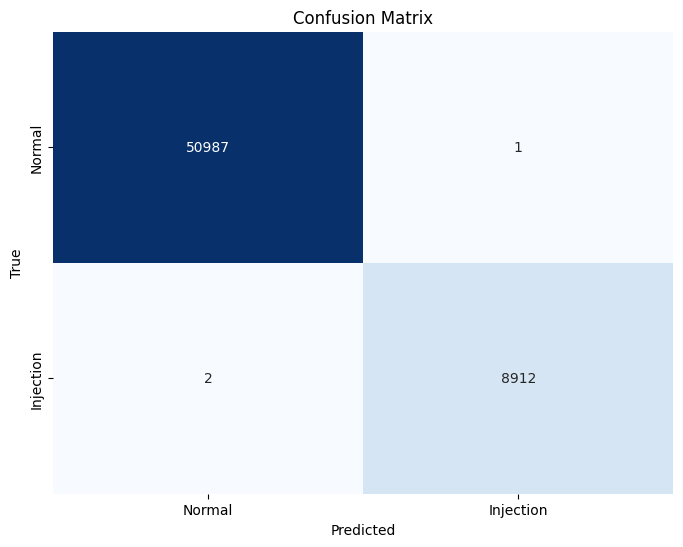

In [ ]:
true_labels = []
predicted_labels = []

with torch.no_grad():  # Disable gradient tracking for evaluation
    for batch in test_data_loader:
        input_data, labels = batch
        logits = model(input_data)

        # Convert logits to predicted labels
        predicted_batch = (logits > 0).long()

        # Append true and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted_batch.cpu().numpy())

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Generate a classification report to get precision, recall, F1-score, etc.
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Injection'], yticklabels=['Normal', 'Injection'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### **CAN IDs Processing**

In [ ]:
selected_columns = source[['CAN ID','Flag']]

# Convert the selected columns to a NumPy array
result = selected_columns.to_numpy()

# If you want the result in the specified format, convert it accordingly
formatted_result = [(x, y) for x, y in result]

window_size = 128
batch_size = len(formatted_result)
Labels = []
Y = [0] * len(formatted_result)
Seq = []

# Loop over the range to create sequences Xi
for i in range(0, batch_size - window_size + 1):
    Xi = [formatted_result[i + j][0] for j in range(window_size)]
    Seq.append(Xi)

# Calculate Y values using the recursive sum
for i in range(len(formatted_result)):
    Y[i] = sum(formatted_result[j][1] for j in range(max(i - window_size + 1, 0), i + 1))

# Loop through the batch
for j in range(0, batch_size - window_size):
    recur_sum_Yi = sum(Y[i] for i in range(j, j + window_size))
    Xj = formatted_result[j][0]

    if recur_sum_Yi == 0:
        Yj = 0
        Labels.append((Xj, Yj))
    else:
        for i in range(j, j + window_size):
            Yi = Y[i]
            if Yi != 0:
                Yj = Yi
                Labels.append((Xj, Yj))

count_0 = 0
count_1 = 0
for _, Yj in Labels:
    if Yj == 0:
        count_0 += 1
    elif Yj == 1:
        count_1 += 1

Labels

[(1349, 0),
 (688, 0),
 (2, 0),
 (339, 0),
 (304, 0),
 (305, 0),
 (320, 0),
 (848, 0),
 (704, 0),
 (880, 0),
 (1087, 0),
 (1088, 0),
 (1264, 0),
 (790, 0),
 (399, 0),
 (608, 0),
 (672, 0),
 (809, 0),
 (1349, 0),
 (688, 0),
 (1072, 0),
 (1201, 0),
 (497, 0),
 (339, 0),
 (2, 0),
 (160, 0),
 (161, 0),
 (848, 0),
 (704, 0),
 (304, 0),
 (305, 0),
 (320, 0),
 (880, 0),
 (1087, 0),
 (1088, 0),
 (1680, 0),
 (790, 0),
 (399, 0),
 (608, 0),
 (672, 0),
 (809, 0),
 (1349, 0),
 (688, 0),
 (2, 0),
 (339, 0),
 (304, 0),
 (305, 0),
 (320, 0),
 (848, 0),
 (704, 0),
 (880, 0),
 (1087, 0),
 (1088, 0),
 (1264, 0),
 (790, 0),
 (399, 0),
 (608, 0),
 (672, 0),
 (809, 0),
 (1349, 0),
 (688, 0),
 (1072, 0),
 (1201, 0),
 (497, 0),
 (339, 0),
 (2, 0),
 (848, 0),
 (880, 0),
 (1087, 0),
 (704, 0),
 (304, 0),
 (305, 0),
 (320, 0),
 (1088, 0),
 (790, 0),
 (399, 0),
 (608, 0),
 (672, 0),
 (809, 0),
 (1349, 0),
 (1520, 0),
 (688, 0),
 (2, 0),
 (339, 0),
 (304, 0),
 (305, 0),
 (320, 0),
 (848, 0),
 (704, 0),
 (880, 0),

In [ ]:
# Create an instance of the model
vocab_size = 65535  # Adjust as needed
embedding_dim = 32  # Adjust as needed
num_layers = 6  # Number of transformer layers
num_heads = 8  # Number of attention heads
ff_dim = 32  # Feedforward dimension
max_seq_length = 1  # Adjust as needed

model = CustomTransformerModel(vocab_size, embedding_dim, num_layers, num_heads, ff_dim, max_seq_length)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert your sequence data to PyTorch tensors (assuming `Seq` is your input sequence data and `Labels` is your target labels)
X_train = torch.tensor(Seq, dtype=torch.long)  # Assuming Seq contains integer tokens
Y_train = torch.tensor([y for _, y in Labels], dtype=torch.long)

# Training loop
epochs = 10
for epoch in range(epochs):
    # Forward pass
    output = model(X_train)

    # Calculate loss
    loss = criterion(output.squeeze(), Y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for monitoring
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


NameError: ignored